In [ ]:
import io
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
import random
random.seed(42)


                                          READ AND CHECK DATASET

In [6]:

data = pd.read_parquet(r"Dataset\Data\train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")

print(data.shape)
print(data.columns)

# check the dataset is balanced or not
np.unique(data['label'].value_counts())

(5120, 2)
Index(['image', 'label'], dtype='object')


array([  49,  724, 1781, 2566])

               DATA AUGMENTATION - Rotation,Width Shifting,Height Shifting,Shear,Zoom,Horizontal Flip

In [7]:

# Define ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

images, labels = [], []
class_counts = Counter(data['label'])  
target_size = {0: 1500, 1: 1500}  

augmented_counts = {0: class_counts[0], 1: class_counts[1]}

for i, row in data.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    label = row['label']

    images.append(img)
    labels.append(label)

    if label in [0, 1] and augmented_counts[label] < target_size[label]:
        img_array = np.array(img)
        img_array = img_array.reshape((1,) + img_array.shape + (1,))  
        
        while augmented_counts[label] < target_size[label]:
            aug_iter = datagen.flow(img_array, batch_size=1)
            aug_img_array = next(aug_iter)[0].astype(np.uint8)  
            aug_img = Image.fromarray(aug_img_array.squeeze())  
            
            images.append(aug_img)
            labels.append(label)
            augmented_counts[label] += 1



images = np.array(images)
# normalizing image
images = images.astype('float32') / 255.0
# reshape image
X_train = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
y_train = np.array(labels)

print(np.unique(y_train,return_counts=True))
print(X_train.shape)
print(y_train.shape)

cv2.imshow('img',X_train[0])
cv2.waitKey(1)
cv2.destroyAllWindows()


(array([0, 1, 2, 3]), array([1500, 1500, 2566, 1781]))
(7347, 128, 128, 1)
(7347,)


                                 BUILD MODEL - CNN                                                                 

In [9]:

def cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


                                         TRAINING

In [28]:

input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))
model = cnn_model(input_shape, num_classes)
model.summary()
model.fit(X_train,y_train,epochs=10,batch_size=4)
model.save('Model/model.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,797,316 (64.08 MB)

 Trainable params: 16,797,316 (64.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 723s 392ms/step - accuracy: 0.5941 - loss: 0.8723
Epoch 2/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 772s 408ms/step - accuracy: 0.8846 - loss: 0.2918
Epoch 3/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 1070s 582ms/step - accuracy: 0.9660 - loss: 0.0920
Epoch 4/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 479s 235ms/step - accuracy: 0.9873 - loss: 0.0360
Epoch 5/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 431s 229ms/step - accuracy: 0.9935 - loss: 0.0215
Epoch 6/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 441s 228ms/step - accuracy: 0.9858 - loss: 0.0388
Epoch 7/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 426s 220ms/step - accuracy: 0.9955 - loss: 0.0161
Epoch 8/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 438s 217ms/step - accuracy: 0.9855 - loss: 0.0448
Epoch 9/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 482s 239ms/step - accuracy: 0.9966 - loss: 0.0122
Epoch 10/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 430s 232ms/step - accuracy: 0.9989 - loss: 0.0052


                                   TESTING & EVALUATION

In [12]:

data = pd.read_parquet(r"Dataset\Data\test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")

label = data['label']
images = []
for i, row in data.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    img = np.array(img)
    cv2.imwrite(f"Dataset/Data/test_images/{i}.jpg",img)
    images.append(img)

images = np.array(images)
# normalizing image
images = images.astype('float32') / 255.0
# reshape image
X_test = images.reshape(1280, 128, 128, 1)
y_test = np.array(label)

print(np.unique(y_test,return_counts=True))
print(X_test.shape)
print(y_test.shape)

model.evaluate(X_test,y_test)
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)


(array([0, 1, 2, 3]), array([172,  15, 634, 459]))
(1280, 128, 128, 1)
(1280,)
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9705 - loss: 0.1979
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step


                                   PERFORMANCE CALCULATION

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cnf = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


Accuracy: 0.97265625
Precision: 0.9732289976862128
Recall: 0.97265625
F1-score: 0.9725622423588088


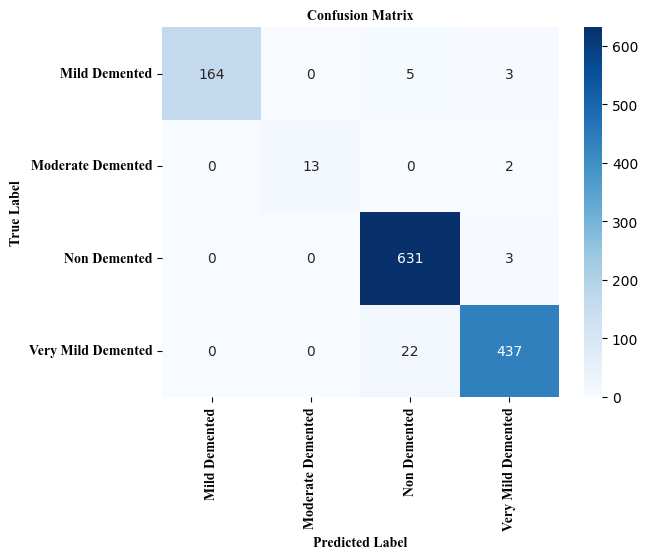

In [14]:
# plot confusion metrix for Random Forest
classes = {0: 'Mild Demented',1: 'Moderate Demented',2: 'Non Demented',3: 'Very Mild Demented'}
class_type = classes.values()
plt.figure()
sns.heatmap(cnf, annot=True,fmt='g', cmap='Blues', xticklabels=class_type, yticklabels=class_type)
plt.xlabel('Predicted Label',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.ylabel('True Label',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.xticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.title('Confusion Matrix',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.savefig('Results/cnf.jpg',dpi=600)
plt.show()